In [1]:
import pandas as pd
import numpy as np
import praw
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import gc
from sklearn import preprocessing

#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

This segment will analyze the frequency of words that appear in the most positively and negatively scored comments from Reddit. The two nltk package downloads are required to tag individual words to their part of speech. This allows us to filter the words we do not believe are relevant to a post's popularity.

In [2]:
#Loads in the json documents for the 180,000 most positively scored and negatively scored comments
positive = pd.read_json("./db/positive_subs.json")
negative = pd.read_json("./db/negative_subs.json")

The word maps will contain every instance of a valid word within the comment texts. The pos_map is a list of parts of speech that will be included in the filtering for our word table.

List with examples
<ul>
  <li>JJ adjective 'big'
</li>
  <li>JJR adjective, comparative 'bigger'
</li>
  <li>JJS adjective, superlative 'biggest'
</li>
  <li>NN noun, singular 'desk'
</li>
  <li>NNS noun plural 'desks'
</li>
  <li>NNP proper noun, singular 'Harrison'
</li>
   <li>NNPS proper noun, plural 'Americans'
</li>
  <li>RB adverb very, silently,
</li>
  <li>RBR adverb, comparative better
</li>
   <li>RBS adverb, superlative best
</li>
  <li>RP particle give up
</li>
  <li>UH interjection errrrrrrrm
</li>
   <li>VB verb, base form take
</li>
  <li>VBD verb, past tense took
</li>
  <li>VBG verb, gerund/present participle taking
</li>
   <li>VBN verb, past participle taken
</li>
  <li>VBP verb, sing. present, non-3d take
</li>
  <li>VBZ verb, 3rd person sing. present takes
</li>
</ul>

The regular expression will filter out all nonalphanumeric characters. The natural language toolkit's tokenizer splits words into tokens based on their criteria for parts of speech. This separates words that have nonalphanumeric characters between them like a hyphen. This is not favorable, since it also allows duplicate words with differing capitalizations within the word. The regular expression will ensure that all words are split on space, and each word does not contain nonsense characters. The filter for these parts of speech is used to more accurately select real english words.

In [3]:
pos_word_map = []
neg_word_map = []
pos_map = ["JJ", "JJR", "JJS", "NN", "NNS", "NNP", "NNPS", "RB", "RBR", "RBS", "RP","UH", "VB", "VBG", "VBD", "VBN", "VBP", "VBZ"]
pattern = re.compile('[\W_]+', re.UNICODE)

This section of code iterates through the positive comment table and copies instances of valid words to the pos_word_map as a tuple of it and the corresponding comment score. This will allow us to measure the relative score of a word in relation to the score of the comments it appears in. Every single word within the text will be assigned the point value of the post it came from, and words that appear multiple times within the text will be weighted with multiple of these assignments. This will increase the positive or negative predictor score of words based on their frequency in high or low scoring points. 

In [4]:
for i, row in positive.iterrows():
    text = row.text
    new_text = text.split()
    results = []
    score = row.score
    for word in new_text:
        temp = pattern.sub('', word).lower()
        if temp != '':
            results.append((temp,score))
    pos_word_map.extend(results)

The rest of the code sections are intermediary steps in creating a cleaned up DataFrame which we can work with. The DataFrames are manipulated in order to translate the information from a word, score tuple Series into a DataFrame. Two DataFrames are then needed in order to cleanly sum up the frequency of each word within the entire corpus of reddit comments for the json records as well as the associated score for each word. The following show the process as these mappings are produced.

In [5]:
#Creates a DataFrame for the word,score tuples
pos_tokens_df = pd.DataFrame(pos_word_map, columns = ['word', 'score'])

In [6]:
#Creates a DataFrame with the frequency of each word in the total pos_word_map
pos_count_df = pd.DataFrame(pos_tokens_df.word.value_counts())
pos_count_df.reset_index(level=0, inplace=True)
pos_count_df.rename(columns={"index":"word", "word":"frequency"}, inplace=True)
pos_count_df.head(10)

,word,frequency
0,the,209834
1,a,137305
2,to,136102
3,i,123571
4,and,119350
5,of,92023
6,you,77556
7,that,72116
8,in,68963
9,it,67261


In [7]:
#Creates a DataFrame for the positively scored words where the raw score is the sum of all of the instances of a word's 
#post score
pos_score_df = pd.DataFrame(pos_word_map)
pos_score_df = pd.DataFrame(pos_score_df)
pos_score_df.reset_index(level=0, inplace=True)
pos_score_df = pd.DataFrame(pos_score_df.groupby(0)[1].sum())
pos_score_df.reset_index(level=0, inplace=True)
pos_score_df.rename(columns={0:"word",1:"raw_score"},inplace=True)
pos_score_df.head(10)

,word,raw_score
0,0,289378
1,00,20749
2,000,32023
3,0000,2884
4,000000,4247
5,00000000000000001,488
6,00000014658994266,555
7,0000002191397973,1110
8,000000httpwwwcolorhexcomcolor000000,940
9,000001,3382


As seen above, the data contains a significant number of words that do not have any meaning in either English or in the context of comment score preditions. These words will be filtered out in a couple of steps. The frequency of each word was initially calculated in order to assist with removing words that appear to have no significance or words that may bias the data too much due to outlier posts that contain infrequently used words.

In [111]:
#Creates a DataFrame with the average score of each word as the raw_score / word frequency
pos_df = pos_count_df.set_index('word').join(pos_score_df.set_index('word'), rsuffix='_r')
pos_df.reset_index(level=0, inplace=True)
pos_df.rename(columns={"score_r":"score"}, inplace=True)
pos_df['average_score'] = pos_df.raw_score / pos_df.frequency
pos_df.head(10)

NameError: name 'pos_count_df' is not defined

It is in this step that the natural language toolkit is used in order to tag each word parsed in the previous segments with the part of speech the word belongs to. This allows us to choose only words from the list of parts of speech as valid entries in the DataFrame. Filtering out words that might either not be English or removing statistical outliers from appearing only a handful of times will make the data more accurate in predicting positively and negatively biased words. The frequency filter was set to 50 after determining a safeguard buffer for words that did not appear to make any sense.

In [9]:
#Creates a DataFrame with the part of speech for each word added
pos_df = pos_df[pos_df.frequency > 50]
pos_tags = nltk.pos_tag(pos_df.word)
pos_tags = pd.DataFrame(pos_tags)
pos_df['part_of_speech'] = pos_tags[1]
pos_df = pos_df[pos_df.part_of_speech.isin(pos_map)]
pos_df = pd.DataFrame(pos_df)
pos_df.reset_index(level=0,drop=True,inplace=True)
pos_df.head()

,word,frequency,raw_score,average_score,part_of_speech
0,i,123571,105821196,856.359469,NN
1,is,61584,51719699,839.823639,VBZ
2,was,47110,40223608,853.823137,VBD
3,have,30279,25534513,843.307672,NN
4,be,28346,23870140,842.099062,VB


It is important to clean up the dataframes that are no longer in use, because the overhead for maintaining the dataframes and arrays in memory are too high. This may cause the kernal to terminate.

In [10]:
#Cleanup for memory
del pos_tokens_df, pos_score_df, pos_word_map, pos_count_df, pos_tags
gc.collect()

34

This section of code will replicate the upper section with regard to the most negatively scored comments.

In [11]:
for i, row in negative.iterrows():
    text = row.text
    new_text = text.split()
    results = []
    score = row.score
    for word in new_text:
        temp = pattern.sub('', word).lower()
        if temp != '':
            results.append((temp,score))
    neg_word_map.extend(results)

In [12]:
#Creates a DataFrame for the word,score tuples
neg_tokens_df = pd.DataFrame(neg_word_map, columns = ['word', 'score'])

In [13]:
#Creates a DataFrame with the frequency of each word in the total pos_word_map
neg_count_df = pd.DataFrame(neg_tokens_df.word.value_counts())
neg_count_df.reset_index(level=0, inplace=True)
neg_count_df.rename(columns={"index":"word", "word":"frequency"}, inplace=True)
neg_count_df.head(10)

,word,frequency
0,the,189783
1,to,140089
2,a,134658
3,you,114409
4,i,108607
5,and,106129
6,of,91741
7,is,82551
8,that,79801
9,it,70022


In [14]:
#Creates a DataFrame for the negatively scored words where the raw score is the sum of all of the instances of a word's 
#post score
neg_score_df = pd.DataFrame(neg_word_map)
neg_score_df = pd.DataFrame(neg_score_df)
neg_score_df.reset_index(level=0, inplace=True)
neg_score_df = pd.DataFrame(neg_score_df.groupby(0)[1].sum())
neg_score_df.reset_index(level=0, inplace=True)
neg_score_df.rename(columns={0:"word",1:"raw_score"},inplace=True)
neg_score_df.head(10)

,word,raw_score
0,0,-17361
1,00,-1407
2,000,-804
3,0000,-34
4,00000000000000000000000000001,-75
5,000000000001,-70
6,00000000000ooooooo00000o0k0kkkkkkk000kkkkkkxkk...,-41
7,00000000001,-49
8,0000000001,-65
9,00000001676,-40


In [15]:
#Creates a DataFrame with the average score of each word as the raw_score / word frequency
neg_df = neg_count_df.set_index('word').join(neg_score_df.set_index('word'), rsuffix='_r')
neg_df.reset_index(level=0, inplace=True)
neg_df.rename(columns={"score_r":"score"}, inplace=True)
neg_df['average_score'] = neg_df.raw_score / neg_df.frequency
neg_df.head(10)

,word,frequency,raw_score,average_score
0,the,189783,-9192689,-48.437895
1,to,140089,-6892504,-49.200894
2,a,134658,-6624772,-49.197018
3,you,114409,-5642931,-49.322440
4,i,108607,-5520607,-50.831042
5,and,106129,-5234321,-49.320365
6,of,91741,-4497583,-49.024787
7,is,82551,-4016658,-48.656685
8,that,79801,-3857343,-48.337026
9,it,70022,-3415431,-48.776542


In [16]:
#Creates a DataFrame with the part of speech for each word added
neg_df = neg_df[neg_df.frequency > 50]
neg_tags = nltk.pos_tag(neg_df.word)
neg_tags = pd.DataFrame(neg_tags)
neg_df['part_of_speech'] = neg_tags[1]
neg_df = neg_df[neg_df.part_of_speech.isin(pos_map)]
neg_df = pd.DataFrame(neg_df)
neg_df.reset_index(level=0,drop=True,inplace=True)
neg_df.head()

,word,frequency,raw_score,average_score,part_of_speech
0,i,108607,-5520607,-50.831042,JJ
1,is,82551,-4016658,-48.656685,VBZ
2,not,44253,-2156621,-48.733894,RB
3,are,41097,-2000903,-48.687325,VBP
4,have,35133,-1719123,-48.931859,VB


In [17]:
#Cleanup for memory
del neg_tokens_df, neg_score_df, neg_word_map, neg_count_df, neg_tags
gc.collect()

27

Now that the data has been organized for preprocessing, we take the sklearn modules to normalize and standardize the data on each of the numeric columns for both the pos_df and neg_df DataFrames. The most important columns to look at are the normalized and standardized average scores, since this represents the relationship between frequency of the word and the word's raw score. The normalization and standardization allow us to make statisical observations about certain words relative to other words in the data set.

In [18]:
df_num_pos = pos_df.select_dtypes(include=[np.number])
df_num_neg = neg_df.select_dtypes(include=[np.number])
df_num_neg = df_num_neg.abs()

min_max_scaler = preprocessing.MinMaxScaler()
standard_scaler = preprocessing.StandardScaler()
pos_df = pos_df.join(pd.DataFrame(min_max_scaler.fit_transform(df_num_pos), columns=df_num_pos.columns, 
                                  index=df_num_pos.index), rsuffix='_normalized')
neg_df = neg_df.join(pd.DataFrame(min_max_scaler.fit_transform(df_num_neg), columns=df_num_neg.columns, 
                                  index=df_num_neg.index), rsuffix='_normalized')
pos_df = pos_df.join(pd.DataFrame(standard_scaler.fit_transform(df_num_pos), columns=df_num_pos.columns, 
                                  index=df_num_pos.index), rsuffix='_standardized')
neg_df = neg_df.join(pd.DataFrame(standard_scaler.fit_transform(df_num_neg), columns=df_num_neg.columns, 
                                  index=df_num_neg.index), rsuffix='_standardized')

This graph shows the normalized average score for both the words in the top 180,000 positive comments in green and the words in the top 180,000 negative comments in orange. The negatively scored words were normalized with their absolute value to present data that can be directly comparable to the positive words.

Positive Comments (Mean Normalized) : 0.2800709489346669
Positive Comments (Std Normalized)  : 0.05624955519896375
Negative Comments (Mean Normalized) : 0.19182946709344129
Negative Comments (Std Normalized)  : 0.05138053744316664
Difference (Mean Normalized)        : 0.0882414818412256
Difference (Std Normalized)         : 0.004869017755797109


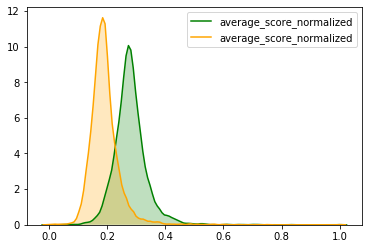

In [21]:
sns.kdeplot(pos_df.average_score_normalized, shade=True, color='Green')
sns.kdeplot(neg_df.average_score_normalized, shade=True, color='Orange')
print("Positive Comments (Mean Normalized) : " + str(pos_df.average_score_normalized.mean()))
print("Positive Comments (Std Normalized)  : " + str(pos_df.average_score_normalized.std()))
print("Negative Comments (Mean Normalized) : " + str(neg_df.average_score_normalized.mean()))
print("Negative Comments (Std Normalized)  : " + str(neg_df.average_score_normalized.std()))
print("Difference (Mean Normalized)        : " + str(pos_df.average_score_normalized.mean() - neg_df.average_score_normalized.mean()))
print("Difference (Std Normalized)         : " + str(pos_df.average_score_normalized.std() - neg_df.average_score_normalized.std()))

The second graph plots the standardized average scores for the positive and negative words. With the data standardized, we can now compare the words across positive and negative DataFrames to determine which words are the most positive, neutral, or negative by frequency and comment score.

Positive Comments (Mean Standardized) : -2.198133383522676e-15
Positive Comments (Std Standardized)  : 1.0000840300829181
Negative Comments (Mean Standardized) : -7.590367503668726e-16
Negative Comments (Std Standardized)  : 1.0000872866933097
Difference (Mean Standardized)        : -1.4390966331558034e-15
Difference (Std Standardized)         : -3.2566103915776523e-06


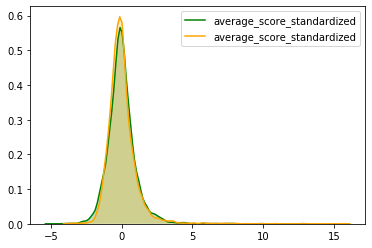

In [23]:
sns.kdeplot(pos_df.average_score_standardized, shade=True, color='Green')
sns.kdeplot(neg_df.average_score_standardized, shade=True, color='Orange')
print("Positive Comments (Mean Standardized) : " + str(pos_df.average_score_standardized.mean()))
print("Positive Comments (Std Standardized)  : " + str(pos_df.average_score_standardized.std()))
print("Negative Comments (Mean Standardized) : " + str(neg_df.average_score_standardized.mean()))
print("Negative Comments (Std Standardized)  : " + str(neg_df.average_score_standardized.std()))
print("Difference (Mean Standardized)        : " + str(pos_df.average_score_standardized.mean() - neg_df.average_score_standardized.mean()))
print("Difference (Std Standardized)         : " + str(pos_df.average_score_standardized.std() - neg_df.average_score_standardized.std()))

This chart shows the top 10 words by average standardized score for positive comments. The distribution skews long tails where the score is many standard deviations above the mean. This can be attributed to the fact that these data sets take a look at the top/lowest 180,000 comments by score out of a dataset that contains 380 million comments. By eliminating the majority of neutrally voted comments by absolute value, some words will be heavily biased due to their low frequency count in relation to their appearance in some highly scored points, whether they be positive or negative. This means that given analysis of enough data points it is highly likely for those top 9 words to fall in the rankings, since the top 9 also comprise entirely out of words that rank below 3700 on their frequency within the corpus.

In [112]:
pos_df.sort_values(by="average_score_standardized", ascending=False).head(10)

,word,frequency,raw_score,average_score,part_of_speech,frequency_normalized,raw_score_normalized,average_score_normalized,frequency_standardized,raw_score_standardized,average_score_standardized
4733,shrimp,69,125890,1824.492754,VBP,0.000146,0.000882,1.000000,-0.169329,-0.135359,12.799915
4335,gilded,78,124731,1599.115385,VBD,0.000219,0.000871,0.833503,-0.165487,-0.135941,9.839701
5280,thor,59,88902,1506.813559,NN,0.000065,0.000532,0.765316,-0.173597,-0.153909,8.627365
4723,wasps,69,99922,1448.144928,NN,0.000146,0.000636,0.721974,-0.169329,-0.148383,7.856783
4961,pucker,65,93365,1436.384615,NN,0.000113,0.000574,0.713286,-0.171036,-0.151671,7.702317
5243,currency,60,85352,1422.533333,NN,0.000073,0.000498,0.703054,-0.173170,-0.155690,7.520388
5264,bloat,60,84753,1412.550000,NN,0.000073,0.000493,0.695679,-0.173170,-0.155990,7.389262
4642,mold,71,97765,1376.971831,JJ,0.000162,0.000616,0.669395,-0.168475,-0.149464,6.921961
3769,glitter,93,126456,1359.741935,JJ,0.000340,0.000887,0.656667,-0.159085,-0.135076,6.695656
324,gold,1403,1887736,1345.499644,JJ,0.010946,0.017536,0.646146,0.400047,0.748222,6.508590


In [113]:
neg_df.sort_values(by="average_score_standardized", ascending=False).head(10)

,word,frequency,raw_score,average_score,part_of_speech,frequency_normalized,raw_score_normalized,average_score_normalized,frequency_standardized,raw_score_standardized,average_score_standardized
4788,diversity,64,-8973,-140.203125,NN,0.000120,0.001293,1.000000,-0.180504,-0.131945,15.730491
2821,inferior,135,-15121,-112.007407,JJ,0.000774,0.002407,0.750928,-0.151974,-0.082178,10.882475
3057,poverty,120,-12046,-100.383333,VBP,0.000636,0.001850,0.648245,-0.158002,-0.107070,8.883814
4995,leftist,60,-5763,-96.050000,VBP,0.000083,0.000712,0.609965,-0.182111,-0.157929,8.138734
4826,edit3,63,-5970,-94.761905,VBP,0.000111,0.000749,0.598587,-0.180905,-0.156254,7.917257
96,ha,4617,-436853,-94.618367,VBP,0.042061,0.078825,0.597319,1.648975,3.331644,7.892577
4374,ours,73,-6700,-91.780822,VBP,0.000203,0.000881,0.572253,-0.176887,-0.150344,7.404685
4773,frequent,64,-5847,-91.359375,JJ,0.000120,0.000727,0.568530,-0.180504,-0.157249,7.332221
5547,chuckle,53,-4831,-91.150943,NN,0.000018,0.000543,0.566689,-0.184924,-0.165474,7.296383
4851,stores,63,-5692,-90.349206,NNS,0.000111,0.000699,0.559607,-0.180905,-0.158504,7.158531


The words from the positive and negative lists are combined to get the standardized score accounting for the difference between the positive commends and negative comments.

In [25]:
inner_join = pd.merge(left=pos_df, right=neg_df, left_on='word',right_on='word')

In [93]:
left = pos_df.loc[np.logical_not(pos_df.word.isin(neg_df.word))]
right = neg_df.loc[np.logical_not(neg_df.word.isin(pos_df.word))]
right[right.select_dtypes(include=[np.number]).columns] *= -1
diff_join = pd.DataFrame(inner_join.word)
diff_join['diff_standardized_score'] = inner_join.average_score_standardized_x - inner_join.average_score_standardized_y
left.rename(columns={"average_score_standardized":"diff_standardized_score"}, inplace=True)
right.rename(columns={"average_score_standardized":"diff_standardized_score"}, inplace=True)
diff_df = pd.concat([diff_join, left[["word","diff_standardized_score"]], right[["word","diff_standardized_score"]]])
diff_df.sort_values(by="diff_standardized_score", ascending=False,inplace=True)
diff_df.reset_index(level=0, drop=True, inplace=True)

Because we have combined both standardized lists and accounted for the negative words as negative values, the distribution looks similar to the one above. The difference in negative values caused the graph to become mirrored on approxmiately x = 0.

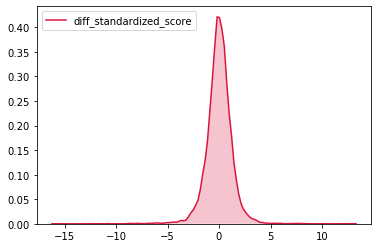

In [94]:
sns.kdeplot(diff_df.diff_standardized_score, shade=True, color='crimson')

This is a list of the top 15 words that predict a positive scoring comment.

In [96]:
diff_df.head(15)

,word,diff_standardized_score
0,shrimp,12.799915
1,gilded,9.839701
2,thor,8.627365
3,currency,8.246487
4,wasps,7.856783
5,pucker,7.702317
6,bloat,7.389262
7,mold,6.921961
8,glitter,6.695656
9,pat,6.041101


This is a list of the top 15 words that predict a negative scoring comment.

In [97]:
diff_df.tail(15)

,word,diff_standardized_score
7034,rpics,-6.232412
7035,stores,-6.457090
7036,gem,-6.631110
7037,frequent,-6.820030
7038,jay,-6.885863
7039,mexicans,-7.033657
7040,iama,-7.541562
7041,ha,-7.823783
7042,edit3,-7.917257
7043,leftist,-8.138734


This is a list of the 10 words on both sides of standardized 0, which should indicate words that are neutral in predicting the positive or negative score of a comment.

In [110]:
diff_df.loc[3559:3579]

,word,diff_standardized_score
3559,gtthe,0.001999
3560,wars,0.001968
3561,hyperbole,0.001552
3562,sherlock,0.001513
3563,slave,0.001009
3564,disrespect,0.000788
3565,ghost,0.000664
3566,bots,0.000504
3567,bartender,0.000266
3568,classmates,0.000234
